In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
from matplotlib import pyplot as  plt
import matplotlib.animation #导入动图包
import math ,random
torch.__version__


'1.3.1'

In [11]:
TIME_STEP = 10  #rnn时序步长(一个time的特征数量）
INPUT_SIZE = 1  #输入维度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #是否使用GPU
H_SIZE = 64 # 隐藏单元个数
EPOCHES = 300 #总共训练次数
h_state = None #隐藏层状态


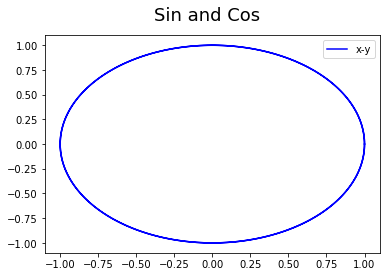

In [12]:
steps = np.linspace(0,np.pi*4 , 256,dtype=np.float32) #在0-2pi之间形成相同间距的256个点
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.figure(1) #新建一个名叫 Figure1的画图窗口
plt.suptitle('Sin and Cos',fontsize='18') #设置标题
# plt.plot(steps,x_np,'-r',label = 'target(cos)')
# plt.plot(steps,y_np,'-b',label = 'sin')
plt.plot(y_np,x_np,'-b',label = 'x-y')
plt.legend(loc='best')
plt.show()


EPOCHS: 19,Loss:0.152132


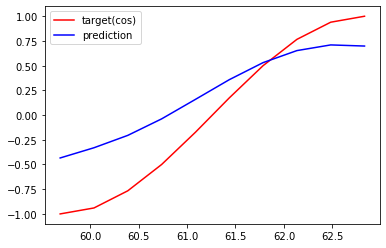

EPOCHS: 39,Loss:0.027954


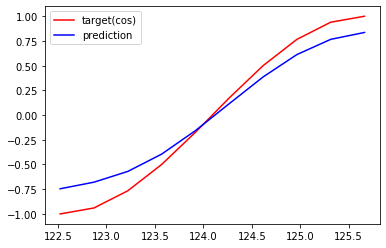

EPOCHS: 59,Loss:0.000960


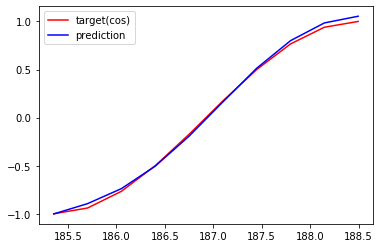

EPOCHS: 79,Loss:0.001282


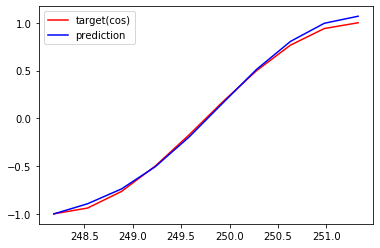

EPOCHS: 99,Loss:0.001163


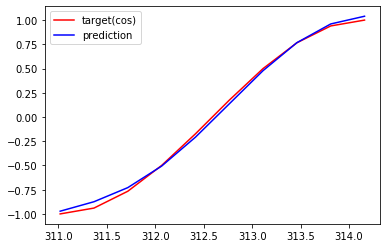

EPOCHS: 119,Loss:0.001402


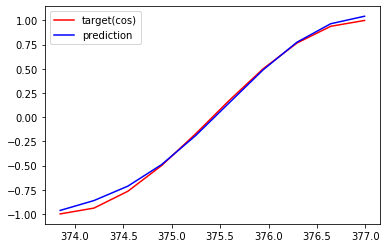

EPOCHS: 139,Loss:0.001465


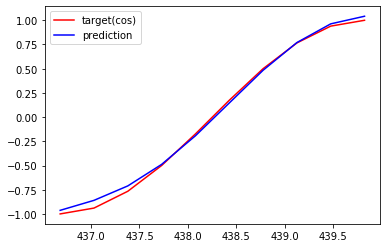

EPOCHS: 159,Loss:0.001225


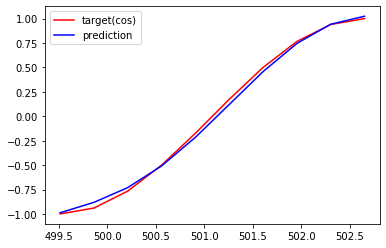

EPOCHS: 179,Loss:0.005144


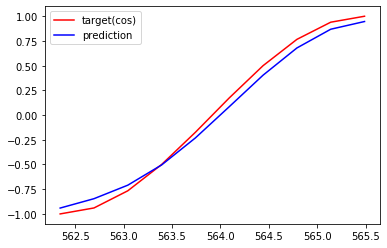

EPOCHS: 199,Loss:0.015484


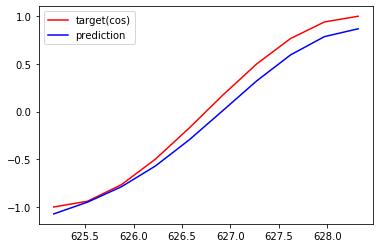

EPOCHS: 219,Loss:0.002844


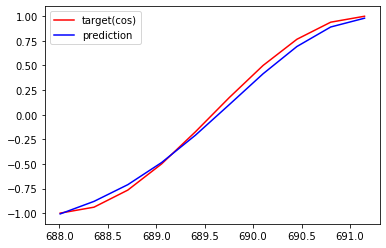

EPOCHS: 239,Loss:0.003196


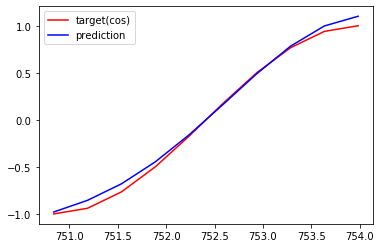

EPOCHS: 259,Loss:0.007493


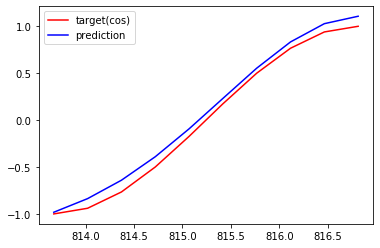

EPOCHS: 279,Loss:0.083732


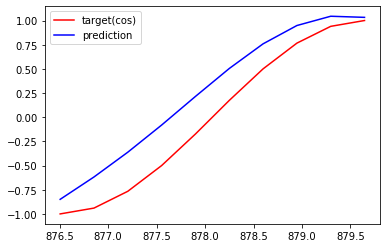

EPOCHS: 299,Loss:0.048769


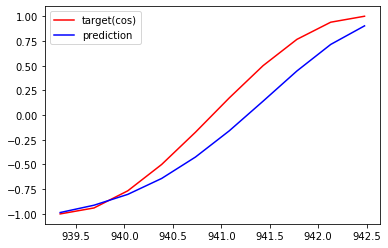

In [13]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.rnn = nn.RNN(                #rnn层
            input_size = INPUT_SIZE,
            hidden_size = H_SIZE,
            num_layers = 1,
            batch_first = True,     
        )
        self.out = nn.Linear(H_SIZE,1)  #输出函数，把64维数字转化为1维的
    def forward(self,x,h_state):
        # x (batch, time_step, input_size)    ----(1,10,1)
        # h_state (n_layers, batch, hidden_size)    ----(1,1,64)
        #虽然设置了batch_first ,但是h_n，c_n这些隐层状态的以一个仍然是layers
        # r_out (batch, time_step, hidden_size)    ----(1,10,64)
        r_out,h_state = self.rnn(x,h_state)
        outs = []     #保存所有预测值
        
        for step in range(r_out.size(1)): #计算每一个步长的预测值
            outs.append(self.out(r_out[:,step,:]))
        return torch.stack(outs,dim=1) , h_state
    
rnn = RNN()
optimizer = optim.Adam(rnn.parameters())  # Adam优化，几乎不用调参
criterion =  nn.MSELoss()
rnn.train()
plt.figure(2)

for step in range(EPOCHES):
    start , end = step * np.pi , (step + 1) * np.pi #一个时间周期
    steps = np.linspace(start,end,TIME_STEP,dtype=np.float32) #在这个周期内形成等间距的10个点
    x_np = np.sin(steps) #此时size为（10，）  
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis,:,np.newaxis]) #size（batch，time_step ,input_size） ，size变成1，10，1
    y = torch.from_numpy(y_np[np.newaxis,:,np.newaxis])
    #向前传播得到预测结果
    prediction,h_state = rnn(x,h_state)
    
    #重置隐藏层状态，切断和前一次迭代的连接
    h_state = h_state.data
    #损失函数
    loss = criterion(prediction,y)
    #梯度清零，损失回传，优化参数
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #可视化效果
    if (step+1) % 20 ==0:
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-', label = 'target(cos)')
        plt.plot(steps, prediction.data.numpy().flatten(), 'b-', label = 'prediction')
        plt.legend(loc='best')
        plt.draw()
        plt.pause(0.01)



